In [1]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
data_path = os.path.join(os.getcwd(), 'data', 'to_analyse')
dataset = load_files(data_path, shuffle=False)
print("n_samples: %d" % len(dataset.data))
print(dataset.target)
print(dataset.target_names)

n_samples: 1461
[0 0 0 ..., 1 1 1]
['hits', 'misses']


In [3]:
dataset.data[0][:500]

b"---\nTitle: 'Healthy\xe2\x80\x99 fast food chains not living up to their claims\nCreated:28/10/2016 6:25 AM\nAuthor:Lyndal Wellard, PhD Student in Nutrition and Dietetics and Senior Nutrition Project Officer at Cancer Council NSW, University of Sydney\nTags:from Inoreader, news\nSource:http://theconversation.com/healthy-fast-food-chains-not-living-up-to-their-claims-67461\n---\nSo-called 'healthier' fast food chains are misleading consumers with claims their foods are lower in salt, sugar and fat than their tra"

In [4]:
# Strip the metadata from the start of the files
for idx, data in enumerate(dataset.data):
    _, meta, content = data.decode("utf-8").split('---\n', maxsplit=2)
    dataset.data[idx] = content

In [5]:
dataset.data[0][:100]

"So-called 'healthier' fast food chains are misleading consumers with claims their foods are lower in"

In [6]:
# split the dataset in training and test set using a specific seed for reproducibility
docs_train, docs_test, y_train, y_test = train_test_split(
    dataset.data, dataset.target, test_size=0.25, random_state=42)

In [7]:
# Vectorise to extract features and filter out tokens that are too rare or too frequent
pipeline = Pipeline([
    ('vect', TfidfVectorizer(min_df=3, max_df=0.95)),
    ('clf', LinearSVC(C=1000)),
])

In [8]:
# Use grid search to find out whether unigrams, bigrams, or tri-grams are more useful.
# Fit the pipeline on the training set using grid search for the parameters
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [9]:
# Print the mean and std for each candidate along with the parameter
# settings for all the candidates explored by grid search.
n_candidates = len(grid_search.cv_results_['params'])
for i in range(n_candidates):
    print(i, 'params - %s; mean - %0.2f; std - %0.2f'
             % (grid_search.cv_results_['params'][i],
                grid_search.cv_results_['mean_test_score'][i],
                grid_search.cv_results_['std_test_score'][i]))

0 params - {'vect__ngram_range': (1, 1)}; mean - 0.76; std - 0.03
1 params - {'vect__ngram_range': (1, 2)}; mean - 0.78; std - 0.01
2 params - {'vect__ngram_range': (1, 3)}; mean - 0.79; std - 0.01


In [10]:
# Predict the outcome on the testing set 
y_predicted = grid_search.predict(docs_test)

In [11]:
# How did the classifier perform?
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

             precision    recall  f1-score   support

       hits       0.80      0.79      0.79       163
     misses       0.83      0.84      0.83       203

avg / total       0.81      0.81      0.81       366



In [12]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[128  35]
 [ 33 170]]


In [13]:
import matplotlib.pyplot as plt
import scikitplot.plotters as skplt

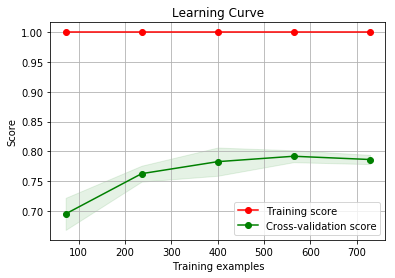

In [14]:
skplt.plot_learning_curve(grid_search, docs_train, y_train)
plt.show()

In [15]:
# Test some specific (new) examples
from newspaper import Article
import requests
url = 'https://deepmind.com/blog/cognitive-psychology/'
r = requests.get(url, verify=False) # False only because of local proxy issues.
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
hit1 = article.text
hit1[:100]

d:\tools\anaconda3\envs\rss\lib\site-packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


'This is known as the ‘black-box’ problem, and it is becoming increasingly important as neural networ'

In [16]:
from newspaper import Article
import requests
url = 'https://deepmind.com/blog/cognitive-psychology/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
hit1 = article.text
url = 'https://theconversation.com/teaching-machines-to-understand-and-summarize-text-78236'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
hit2 = article.text
url = 'https://www.theguardian.com/football/2017/jul/07/chelsea-romelu-lukaku-offer-match-manchester-united'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss1 = article.text
url = 'https://arstechnica.com/business/2017/07/renewables-have-briefly-exceeded-nuclear-for-the-first-time-in-decades/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss2 = article.text

d:\tools\anaconda3\envs\rss\lib\site-packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
d:\tools\anaconda3\envs\rss\lib\site-packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
d:\tools\anaconda3\envs\rss\lib\site-packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
d:\tools\anaconda3\envs\rss\lib\site-packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Un

In [17]:
url = 'https://arstechnica.com/tech-policy/2017/09/jury-finds-nintendo-wii-infringes-dallas-inventors-patent-awards-10m/'
r = requests.get(url, verify=False)
article = Article(url, fetch_images=False)
article.download(input_html=r.text)
article.parse()
miss3 = article.text

d:\tools\anaconda3\envs\rss\lib\site-packages\urllib3\connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [18]:
docs_new = [hit1, hit2, miss1, miss2, miss3]
predicted = grid_search.predict(docs_new)
print(predicted)
for doc, category in zip(['hit1', 'hit2', 'miss1', 'miss2', 'miss3'], predicted):
     print('%r => %s' % (doc, dataset.target_names[category]))

[0 1 1 1 1]
'hit1' => hits
'hit2' => misses
'miss1' => misses
'miss2' => misses
'miss3' => misses


In [19]:
grid_search.decision_function(docs_new)

array([-0.35038703,  0.55853591,  1.06028395,  0.35287145,  0.12730503])

In [20]:
from sklearn.naive_bayes import BernoulliNB
pipeline = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.95, stop_words='english')),
    ('clf', BernoulliNB()),
])
pipeline.fit(docs_train, y_train)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=3,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
 ... vocabulary=None)), ('clf', BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True))])

In [21]:
y_predicted = pipeline.predict(docs_test)
print(metrics.classification_report(y_test, y_predicted,
                                    target_names=dataset.target_names))

             precision    recall  f1-score   support

       hits       0.76      0.63      0.68       163
     misses       0.74      0.84      0.78       203

avg / total       0.74      0.74      0.74       366



In [22]:
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[[102  61]
 [ 33 170]]


In [23]:
docs_new = [hit1, hit2, miss1, miss2, miss3]
predicted = pipeline.predict(docs_new)
print(predicted)
for doc, category in zip(['hit1', 'hit2', 'miss1', 'miss2', 'miss3'], predicted):
     print('%r => %s' % (doc, dataset.target_names[category]))

[1 1 1 1 1]
'hit1' => misses
'hit2' => misses
'miss1' => misses
'miss2' => misses
'miss3' => misses


In [24]:
pipeline.predict_proba(docs_new)

array([[  1.11187656e-23,   1.00000000e+00],
       [  2.03911738e-42,   1.00000000e+00],
       [  1.19717142e-47,   1.00000000e+00],
       [  5.84286253e-28,   1.00000000e+00],
       [  2.89294801e-36,   1.00000000e+00]])